### Math
- Resource is defined as $res$

$$0<=res<=1$$

- Logistic population growth:

$$\frac{dN}{dt} = {\color{red}r}N(1-\frac{N}{K})$$

where $\color{red}r$ is modified as "resource" times "birth rate at max resource"

$$\color{red}{r=res\times bA}$$

which means more resource more growth. Actually $\color{red}{r}$ is not ture birth rate because RHS also has factor $(1-\frac{N}{K})$ for logistic assumption.


- Population diffusion

$$\frac{\partial N}{\partial t} = {\color{red}D}(\frac{\partial^2 N}{\partial x^2}+\frac{\partial^2 N}{\partial y^2})+\frac{\partial {\color{red}D}\partial N}{\partial x^2}+\frac{\partial {\color{red}D}\partial N}{\partial y^2}$$

where $\color{red}D$ is modified as "1-resource" times "diffusion rate at 0 resource"
$$\color{red}{D=(1-res)\times dA}$$

which means more resource less travelling.

When considering both the math models above, we have 

$$\frac{\partial N}{\partial t} = {\color{red}r}N(1-\frac{N}{K}) + {\color{red}D}(\frac{\partial^2 N}{\partial x^2}+\frac{\partial^2 N}{\partial y^2})+\frac{\partial {\color{red}D}\partial N}{\partial x^2}+\frac{\partial {\color{red}D}\partial N}{\partial y^2}$$

### Numerical calculation
Above is solved by finite difference method. We use forward-in-time and backward-in-space for 1st derivative and centered difference for 2nd derivative to solve explicitly.
The scheme is basically

$$\frac{\partial N}{\partial t}\simeq\frac{N^{n+1}_{i,j}-N^{n}_{i,j}}{\Delta t}$$
　
$$\frac{\partial N}{\partial x}\simeq\frac{N^{n}_{i,j}-N^{n}_{i-1,j}}{\Delta x}$$
　
$$\frac{\partial^2 N}{\partial x^2}\simeq\frac{N^{n}_{i+i,j}-2N^{n}_{i,j}+N^{n}_{i-1,j}}{\Delta x^2}...$$

where n, i and j correspond to time, x and y axis.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

def disp_a(m, d, levels, title = None):
    xA = int((m.shape[1]-1)*d)
    yA = int((m.shape[0]-1)*d)
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap("jet")
    cmap.set_over('grey')
    cmap.set_under('black')
    cl = ax.contourf(m, levels, cmap=cmap)
    fig.colorbar(cl)
    ax.set_xticks(np.arange(0, m.shape[1], m.shape[1]//5))
    ax.set_xticklabels(np.arange(0, xA+1, xA//5))
    ax.set_yticks(np.arange(0, m.shape[0], m.shape[0]//5))
    ax.set_yticklabels(np.arange(0, yA+1, yA//5))
    if title: plt.title(title)
    plt.show()
    
class resource_map:
    def __init__(self, xA, yA, d):
        self.d = d              # d = mesh width, length [km]
        self.x = int(xA/d)+1    # xA = area width [km]
        self.y = int(yA/d)+1    # yA = area length [km]
        self.rm = np.zeros((self.y, self.x), dtype="float")
    def random(self, ex, ave = 0.5, flu = 0.5, x0 = 0, y0 = 0, xl = None, yl = None):
        if x0 != 0: x0 = int(x0 / self.d)
        if y0 != 0: y0 = int(y0 / self.d)
        if xl is None: xl = self.x-x0
        else: xl = int(xl/self.d)+1
        if yl is None: yl = self.y-y0
        else: yl = int(yl/self.d)+1
        temp = np.zeros((yl+2*ex, xl+2*ex), dtype="float")
        for i in range(yl+2*ex):
            for j in range(xl+2*ex):
                temp[i][j] = random.uniform(ave-flu, ave+flu)
        for i in range(yl):
            for j in range(xl):
                self.rm[i+y0][j+x0] = np.average(temp[i:i+2*ex+1, j:j+2*ex+1])
    def disp(self, title = None):
        levels = np.arange(0, 1, 0.01)
        disp_a(self.rm, self.d, levels, title)

class animal:
    def __init__(self, bA, dA, k):
        self.bA = bA         # bA = birth rate at max resource [Births / year / population]
        self.k = k           # k = maximum population in 1km*1km [population]
        self.dA = dA         # dA = diffusion rate at 0 resource [km^2 / year]

class population_map:
    def __init__(self, res, ani):
        self.res = res
        self.ani = ani
        self.pm = np.zeros((res.y, res.x), dtype="float")
        self.data = []
    def run(self, t, dt):
        n = int(t / dt)
        for i in range(n):
            growth = self.res.rm * self.ani.bA * self.pm * (1 - self.pm/self.res.d**2/self.ani.k) * dt
            diffusion = (1 - self.res.rm) * self.ani.dA * (np.roll(self.pm,1,0)+np.roll(self.pm,-1,0)+np.roll(self.pm,1,1)+np.roll(self.pm,-1,1)-4*self.pm) / self.res.d**2 * dt
            #diffusion += self.ani.dA * ((np.roll(self.res.rm,1,0)-np.roll(self.res.rm,-1,0))*(np.roll(self.pm,-1,0)-np.roll(self.pm,1,0)) + (np.roll(self.res.rm,1,1)-np.roll(self.res.rm,-1,1))*(np.roll(self.pm,-1,1)-np.roll(self.pm,1,1))) / 4 / self.res.d**2 * dt
            diffusion += self.ani.dA * ((np.roll(self.res.rm,1,0)-self.res.rm)*(self.pm-np.roll(self.pm,1,0)) + (np.roll(self.res.rm,1,1)-self.res.rm)*(self.pm-np.roll(self.pm,1,1))) / self.res.d**2 * dt
            self.pm += growth + diffusion
            self.pm[:,0] = 0; self.pm[:,self.res.x-1] = 0; self.pm[0,:] = 0; self.pm[self.res.y-1,:] = 0
    def disp(self, title = None):
        levels = np.arange(0, np.max(self.pm)+1, 1)
        disp_a(self.pm, self.res.d, levels, title)
    def run_output_vtk(self, t, dt):
        n = int(t / dt)
        self.data.append(self.pm.copy())
        for i in range(n):
            self.run(dt, dt)
            self.data.append(self.pm.copy())
        with open('pop.vtk', mode='w') as fw:
            fw.write('# vtk DataFile Version 4.0\n')
            fw.write('pop\n')
            fw.write('ASCII\n\n')
            fw.write('DATASET STRUCTURED_GRID\n')
            fw.write('DIMENSIONS {0} {1} {2}\n'.format(self.res.rm.shape[0], self.res.rm.shape[1], n+1))
            fw.write('POINTS {0} float\n'.format(self.res.rm.shape[1]*self.res.rm.shape[0]*(n+1)))
            for i in range(n+1):
                for j in range(self.res.rm.shape[1]):
                    for k in range(self.res.rm.shape[0]):
                        fw.write('{0} {1} {2}\n'.format(j*self.res.d, k*self.res.d, i/5))
            fw.write('\n')
            fw.write('POINT_DATA {0}\n'.format(self.res.rm.shape[1]*self.res.rm.shape[0]*(n+1)))
            fw.write('SCALARS pop float\n')
            fw.write('LOOKUP_TABLE default\n')
            for i in range(n+1):
                for j in range(self.res.rm.shape[1]):
                    for k in range(self.res.rm.shape[0]):
                        temp = self.data[i][k][j]
                        if temp < 1: temp = 0
                        fw.write('{0:.5g}\n'.format(temp))

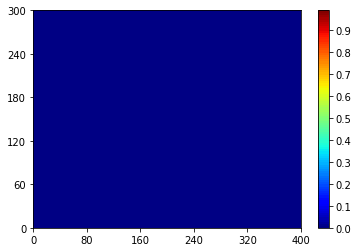

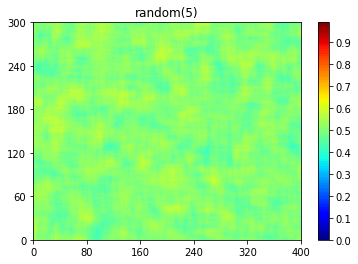

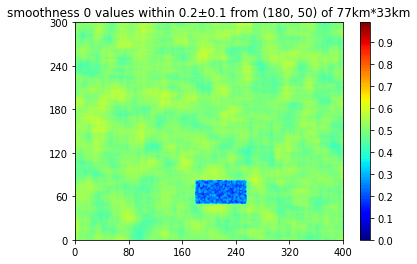

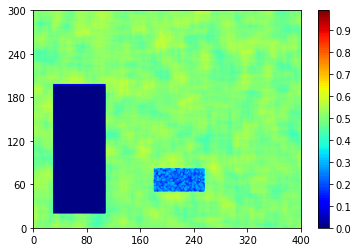

In [2]:
# resource map demonstration
m1 = resource_map(400, 300, 2)                 # generate m1 as an empty resource map of 400km*300km by 2km*2km mesh
m1.disp()                                      # display map m1
m1.random(5)                                   # give m1 random values; map is more smooth when argument is set to be larger 
m1.disp("random(5)")                           # display map function can pass figure title
m1.random(0, 0.2, 0.1, 180, 50, 77, 33)        # give m1 random values(advanced); arguments are (smoothness, average, fluctuation, origin x, origin y, width, length)
m1.disp("smoothness 0 values within 0.2±0.1 from (180, 50) of 77km*33km") 
m1.rm[10:100, 15:55] = 0                       # set values for m1 manually
m1.disp()

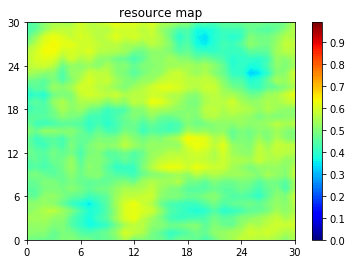

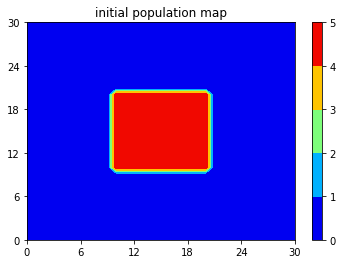

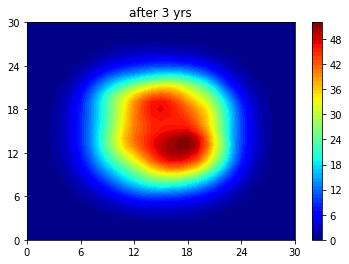

In [3]:
# simulation demonstration
res = resource_map(30, 30, 1)       # create a new resource map "res" of 30km*30km with 1km mesh
res.random(2)                       # randomize the resource
ani = animal(2, 3, 100)             # create a animal type "ani" with bA, dA, k
# bA = birth rate at max resource [Births / year / population]
# dA = diffusion rate at 0 resource [km^2 / year]
# k = maximum population in 1km*1km [population]     These unit settings may be wrong plz check if you can.

p1 = population_map(res, ani)       # create a new population map for animal "ani" to live in the setting of "res"
p1.res.disp("resource map")         # the class fuction is inherited, you can use p1.res.random too 
p1.pm[10:21, 10:21] = 5             # set initial population
p1.disp("initial population map")   # population_map.disp can display the 2d-map for population just like resource_map.disp 
p1.run(3, 0.01)                     # population_map.run(duration, precision), the program will run the simulation time/precision times
p1.disp("after 3 yrs") 

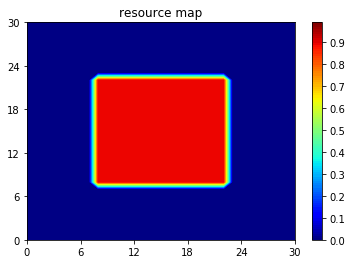

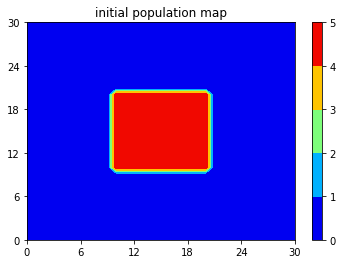

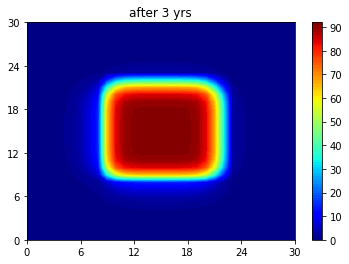

In [4]:
res = resource_map(30, 30, 1)
res.rm[8:23, 8:23] = 0.9
ani = animal(2, 3, 100)
p1 = population_map(res, ani)
p1.res.disp("resource map")
p1.pm[10:21, 10:21] = 5
p1.disp("initial population map")
p1.run(3, 0.1)
p1.disp("after 3 yrs")

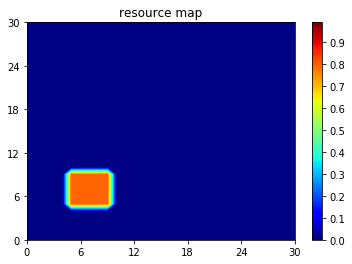

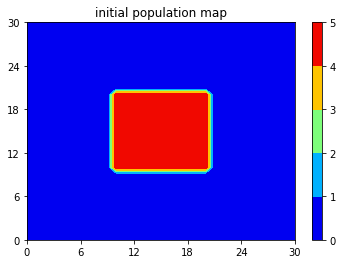

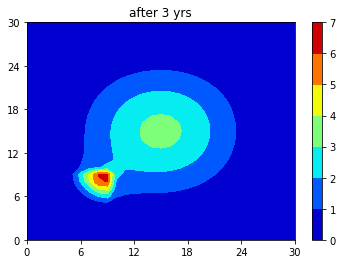

In [7]:
res = resource_map(30, 30, 1)
res.rm[5:10, 5:10] = 0.8
ani = animal(2, 3, 100)
p1 = population_map(res, ani)
p1.res.disp("resource map")
p1.pm[10:21, 10:21] = 5
p1.disp("initial population map")
p1.run(3, 0.01)
p1.disp("after 3 yrs")

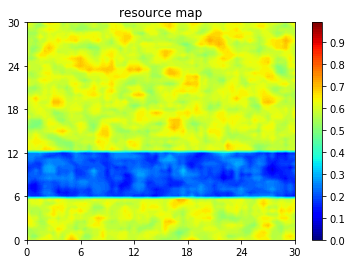

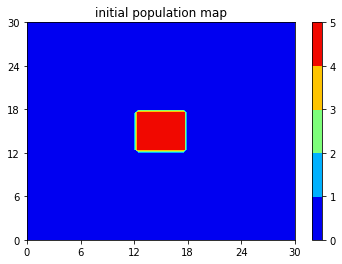

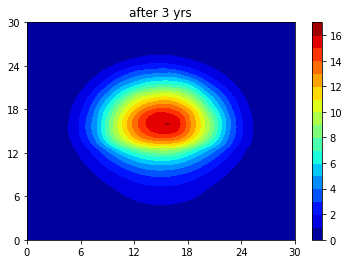

In [6]:
res = resource_map(30, 30, 0.5)
res.random(1, ave=0.6, flu=0.2)
res.random(1, ave=0.2, flu=0.2, y0=6, yl=6)
ani = animal(2, 5, 100)
p1 = population_map(res, ani)
p1.res.disp("resource map")
p1.pm[25:36, 25:36] = 5
p1.disp("initial population map")

# Use population_map.run_output_vtk(duration, precision) to run simulation and output a vtk file
p1.run_output_vtk(3, 0.01)
p1.disp("after 3 yrs")